Project #1


In [24]:
# Import 
import warnings
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

#To ignore all warnings
warnings.filterwarnings('ignore')

In [25]:
# File Path
general_data_to_load = Path("Resources/Hospital_General_Information.csv")
score_data_to_load = Path("Resources/hvbp_tps.csv")

# Read School and Student Data File and store into Pandas DataFrames
general_data = pd.read_csv(general_data_to_load, encoding='latin1')
score_data = pd.read_csv(score_data_to_load)

# Combine the data from the files into a single dataset
hospital_data_complete = pd.merge(general_data, score_data, how="left", left_on='Provider ID', right_on="Facility ID")

# Make an output for the new dataset
output_file_path= 'hospital_data_complete.csv'
hospital_data_complete.to_csv(output_file_path, index=False)
hospital_data_complete=pd.read_csv(output_file_path)


hospital_data_complete

,Provider ID,Hospital Name,Address_x,City,State_x,ZIP Code_x,County Name,Phone Number,Hospital Type,Hospital Ownership,...,County/Parish,Unweighted Normalized Clinical Outcomes Domain Score,Weighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Weighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Weighted Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,HOUSTON,38.33333333,9.583333333,16,4,8,2,0,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,MARSHALL,28,7,6,1.5,22,5.5,30,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,LAUDERDALE,0,0,6,1.5,48,12,0,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,...,COVINGTON,6.666666667,2.222222222,24,8,Not Available,Not Available,50,16.66666667,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,670118,FIRST TEXAS HOSPITAL,9922 LOUETTA RD,HOUSTON,TX,77070,HARRIS,8442641435,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4808,640001,LBJ TROPICAL MEDICAL CENTER,FAGAALU VILLAGE,PAGO PAGO,AS,96799,NaN,6846334590,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4809,650001,GUAM MEMORIAL HOSPITAL AUTHORITY,85O GOV CARLOS G CAMACHO ROAD,TAMUNING,GU,96913,NaN,6716472552,Acute Care Hospitals,Government - Local,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4810,650003,GUAM REGIONAL MEDICAL CITY,133 ROUTE 3,DEDEDO,GU,96929,NaN,6716455500,Acute Care Hospitals,Voluntary non-profit - Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#Calculate the number of hospitals
hospital_unique_count=hospital_data_complete['Hospital Name'].nunique()
print("Number of unique hospitals:",hospital_unique_count)
print (hospital_data_complete.columns)

Number of unique hospitals: 4623
Index(['Provider ID', 'Hospital Name', 'Address_x', 'City', 'State_x',
       'ZIP Code_x', 'County Name', 'Phone Number', 'Hospital Type',
       'Hospital Ownership', 'Emergency Services',
       'Meets criteria for meaningful use of EHRs', 'Hospital overall rating',
       'Hospital overall rating footnote', 'Mortality national comparison',
       'Mortality national comparison footnote',
       'Safety of care national comparison',
       'Safety of care national comparison footnote',
       'Readmission national comparison',
       'Readmission national comparison footnote',
       'Patient experience national comparison',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national com

In [27]:
#del hospital_data_complete['Facility Name'] #,['Address_y'], ['City/Town'],
       #['State_y'], ['ZIP Code_y'], ['County/Parish']

# Drop all rows with missing information
#hospital_data_complete = hospital_data_complete.dropna(how='any')
#hospital_data_complete
# Identify incomplete rows
hospital_data_complete.count()

Provider ID                                                         4812
Hospital Name                                                       4812
Address_x                                                           4812
City                                                                4812
State_x                                                             4812
ZIP Code_x                                                          4812
County Name                                                         4797
Phone Number                                                        4812
Hospital Type                                                       4812
Hospital Ownership                                                  4812
Emergency Services                                                  4812
Meets criteria for meaningful use of EHRs                           4669
Hospital overall rating                                             4812
Hospital overall rating footnote                   

In [28]:
hospital_data_df = pd.DataFrame({
    'Provider ID': hospital_data_complete['Provider ID'],
    'Hospital Name': hospital_data_complete['Hospital Name'],
    'Address': hospital_data_complete['Address_x'],  # Renamed to 'Address'
    'City': hospital_data_complete['City'],
    'State': hospital_data_complete['State_x'],      # Renamed to 'State'
    'ZIP Code': hospital_data_complete['ZIP Code_x'],# Renamed to 'Zip Code'
    'County Name': hospital_data_complete['County Name'],
    'Phone Number': hospital_data_complete['Phone Number'],
    'Hospital Type': hospital_data_complete['Hospital Type'],
    'Hospital Ownership': hospital_data_complete['Hospital Ownership'],
    'Emergency Services': hospital_data_complete['Emergency Services'],
    'Meets criteria for meaningful use of EHRs': hospital_data_complete['Meets criteria for meaningful use of EHRs'],
    'Hospital overall rating': hospital_data_complete['Hospital overall rating'],
    'Weighted Normalized Clinical Outcomes Domain Score': hospital_data_complete['Weighted Normalized Clinical Outcomes Domain Score'],
    'Weighted Person And Community Engagement Domain Score': hospital_data_complete['Weighted Person And Community Engagement Domain Score'],
    'Weighted Safety Domain Score': hospital_data_complete['Weighted Safety Domain Score'],
    'Weighted Efficiency And Cost Reduction Domain Score': hospital_data_complete['Weighted Efficiency And Cost Reduction Domain Score'],
    'Total Performance Score': hospital_data_complete['Total Performance Score']
})

hospital_data_df

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Weighted Normalized Clinical Outcomes Domain Score,Weighted Person And Community Engagement Domain Score,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,9.583333333,4,2,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,7,1.5,5.5,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,0,1.5,12,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,2.222222222,8,Not Available,16.66666667,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,Y,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,670118,FIRST TEXAS HOSPITAL,9922 LOUETTA RD,HOUSTON,TX,77070,HARRIS,8442641435,Acute Care Hospitals,Proprietary,Yes,NaN,Not Available,NaN,NaN,NaN,NaN,NaN
4808,640001,LBJ TROPICAL MEDICAL CENTER,FAGAALU VILLAGE,PAGO PAGO,AS,96799,NaN,6846334590,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,Not Available,NaN,NaN,NaN,NaN,NaN
4809,650001,GUAM MEMORIAL HOSPITAL AUTHORITY,85O GOV CARLOS G CAMACHO ROAD,TAMUNING,GU,96913,NaN,6716472552,Acute Care Hospitals,Government - Local,Yes,Y,3,NaN,NaN,NaN,NaN,NaN
4810,650003,GUAM REGIONAL MEDICAL CITY,133 ROUTE 3,DEDEDO,GU,96929,NaN,6716455500,Acute Care Hospitals,Voluntary non-profit - Private,Yes,NaN,Not Available,NaN,NaN,NaN,NaN,NaN


In [29]:
# Drop all rows with missing information
# First, drop rows with any NaN values
hospital_data_df = hospital_data_df.dropna(how='any')

# Then, drop rows where 'Not Available' is present in any column
hospital_data_df = hospital_data_df[~hospital_data_df.isin(['Not Available']).any(axis=1)]

columns_to_convert = ['Hospital overall rating',
                      'Weighted Normalized Clinical Outcomes Domain Score',
                      'Weighted Person And Community Engagement Domain Score',
                      'Weighted Safety Domain Score',
                      'Weighted Efficiency And Cost Reduction Domain Score']

new_hospital_data_df = hospital_data_df.copy()  # Copy the original DataFrame

for col in columns_to_convert:

    new_hospital_data_df[col] = new_hospital_data_df[col].astype(float)

new_hospital_data_df.dtypes
new_hospital_data_df

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Weighted Normalized Clinical Outcomes Domain Score,Weighted Person And Community Engagement Domain Score,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,9.583333,4.00,2.0,0.0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,7.000000,1.50,5.5,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2.0,0.000000,1.50,12.0,0.0,13.500000
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2.0,3.750000,4.00,4.0,2.5,14.250000
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,Yes,Y,3.0,3.125000,3.50,17.5,0.0,24.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,BELL,2549538342,Acute Care Hospitals,Proprietary,Yes,Y,4.0,2.500000,6.50,12.5,0.0,21.500000
4780,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,COLLIN,4697642200,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,4.0,9.500000,5.75,11.5,2.5,29.250000
4782,670085,TEXAS HEALTH HARRIS METHODIST HOSPITAL ALLIANCE,10864 TEXAS HEALTH TRAIL,FORT WORTH,TX,76244,TARRANT,6822122000,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,4.0,1.875000,4.00,21.5,0.0,27.375000
4784,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,BRAZOS,9796913701,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,4.0,4.583333,9.00,7.0,2.5,23.083333


In [39]:
rating_by_state_count = new_hospital_data_df.groupby('State')['Hospital overall rating'].count()
clinical_by_state_count = new_hospital_data_df.groupby('State')['Weighted Normalized Clinical Outcomes Domain Score'].count()
person_score_by_state_count = new_hospital_data_df.groupby('State')['Weighted Person And Community Engagement Domain Score'].count()
safety_by_state_count = new_hospital_data_df.groupby('State')['Weighted Safety Domain Score'].count()
efficiency_by_state_count = new_hospital_data_df.groupby('State')['Weighted Efficiency And Cost Reduction Domain Score'].count()
performance_total_by_state_count = new_hospital_data_df.groupby('State')['Total Performance Score'].count()

by_state_df_count=pd.DataFrame({'Hospital Rate Count':rating_by_state_count,'Weighted Normalized Clinical Outcomes Domain Score Count':clinical_by_state_count,
                          'Weighted Person And Community Engagement Domain Score Count':person_score_by_state_count, 'Weighted Safety Domain Score Count':safety_by_state_count,
                          'Weighted Efficiency And Cost Reduction Domain Score Count':efficiency_by_state_count, 
                          'Total Performance Score Count':performance_total_by_state_count})

by_state_df_count

,Hospital Rate Count,Weighted Normalized Clinical Outcomes Domain Score Count,Weighted Person And Community Engagement Domain Score Count,Weighted Safety Domain Score Count,Weighted Efficiency And Cost Reduction Domain Score Count,Total Performance Score Count
State,,,,,,
AK,5,5,5,5,5,5
AL,39,39,39,39,39,39
AR,23,23,23,23,23,23
AZ,41,41,41,41,41,41
CA,194,194,194,194,194,194
CO,33,33,33,33,33,33
CT,21,21,21,21,21,21
DC,5,5,5,5,5,5
DE,5,5,5,5,5,5


In [31]:
rating_by_state = new_hospital_data_df.groupby('State')['Hospital overall rating'].mean()
clinical_by_state = new_hospital_data_df.groupby('State')['Weighted Normalized Clinical Outcomes Domain Score'].mean()
person_score_by_state = new_hospital_data_df.groupby('State')['Weighted Person And Community Engagement Domain Score'].mean()
safety_by_state = new_hospital_data_df.groupby('State')['Weighted Safety Domain Score'].mean()
efficiency_by_state = new_hospital_data_df.groupby('State')['Weighted Efficiency And Cost Reduction Domain Score'].mean()
performance_total_by_state = new_hospital_data_df.groupby('State')['Total Performance Score'].mean()

by_state_df=pd.DataFrame({'Hospital Rate Average':rating_by_state,'Weighted Normalized Clinical Outcomes Domain Score Avg':clinical_by_state,
                          'Weighted Person And Community Engagement Domain Score Avg':person_score_by_state, 'Weighted Safety Domain Score Avg':safety_by_state,
                          'Weighted Efficiency And Cost Reduction Domain Score Avg':efficiency_by_state, 
                          'Total Performance Score Avg':performance_total_by_state})

by_state_df

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
AK,2.800000,4.450000,4.650000,11.566667,17.500000,38.166667
AL,2.820513,3.475427,4.525641,8.787393,4.166667,20.955128
AR,2.521739,4.961957,3.358696,9.181159,0.108696,17.610507
AZ,2.975610,5.130081,2.530488,7.914634,4.024390,19.599593
CA,2.840206,6.242698,2.746134,8.344287,4.072165,21.405284
CO,3.484848,6.102273,5.053030,8.834596,3.636364,23.626263
CT,2.619048,6.376984,2.869048,9.446429,2.023810,20.716270
DC,1.600000,9.058333,1.800000,6.500000,2.500000,19.858333
DE,3.600000,5.050000,2.800000,8.700000,0.000000,16.550000


In [32]:
# Sort the schools by `% Overall Passing` in descending order and display the top 5 rows.
top_states =by_state_df.sort_values(["Total Performance Score Avg"], ascending=False) 
top_states.head(10)

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
AK,2.800000,4.450000,4.650000,11.566667,17.500000,38.166667
OR,2.916667,5.357639,4.375000,7.409722,15.312500,32.454861
MN,3.541667,8.625000,5.677083,5.906250,10.729167,30.937500
WI,3.581395,5.188953,5.755814,8.385659,9.011628,28.342054
MT,3.714286,5.642857,4.321429,10.053571,8.214286,28.232143
RI,3.500000,5.619792,5.968750,9.942708,5.937500,27.468750
WA,2.947368,5.677632,2.888158,7.323465,10.526316,26.415570
SD,3.800000,6.850000,5.000000,10.975000,3.500000,26.325000
HI,3.555556,4.347222,4.222222,5.777778,10.833333,25.180556


In [22]:
lowest_states =by_state_df.sort_values(["Total Performance Score Avg"], ascending=True) 
lowest_states.head(10)

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
WV,2.666667,3.199074,3.013889,5.930556,2.222222,14.365741
NM,2.416667,3.479167,2.229167,5.784722,4.791667,16.284722
DE,3.600000,5.050000,2.800000,8.700000,0.000000,16.550000
NJ,2.542373,5.461158,2.529661,8.007768,0.762712,16.761299
IN,3.607843,4.160131,4.676471,7.036765,1.372549,17.245915
AR,2.521739,4.961957,3.358696,9.181159,0.108696,17.610507
LA,3.050000,3.165625,6.437500,7.906250,0.437500,17.946875
SC,3.243243,3.670045,4.722973,8.623874,1.081081,18.097973
NV,2.058824,6.284314,1.941176,8.014706,2.058824,18.299020


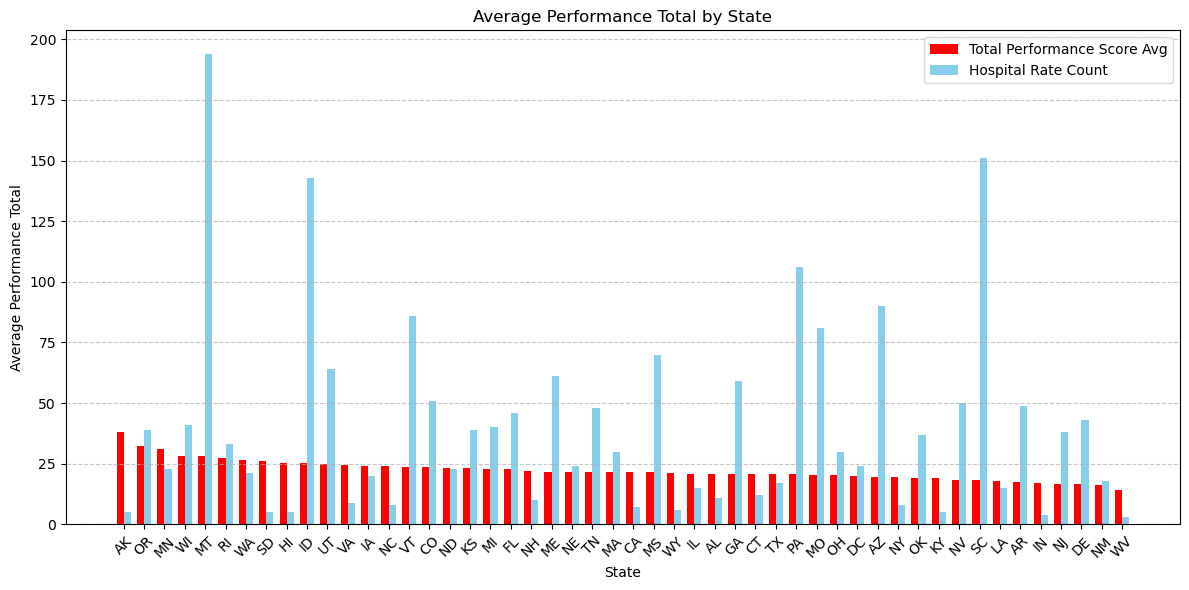

In [42]:

bar_width = 0.35

# Center positions for each group of bars
x = range(len(top_states.index))

# Plotting
plt.figure(figsize=(12, 6))

# Plot the first set of bars
plt.bar(x, top_states['Total Performance Score Avg'], width=bar_width, color='red', label='Total Performance Score Avg')

# Plot the second set of bars next to the first one
plt.bar([i + bar_width for i in x], by_state_df_count['Hospital Rate Count'], width=bar_width, color='skyblue', label='Hospital Rate Count')

plt.title('Average Performance Total by State')
plt.xlabel('State')
plt.ylabel('Average Performance Total')
plt.xticks([i + bar_width/2 for i in x], top_states.index, rotation=45)  # Rotating x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

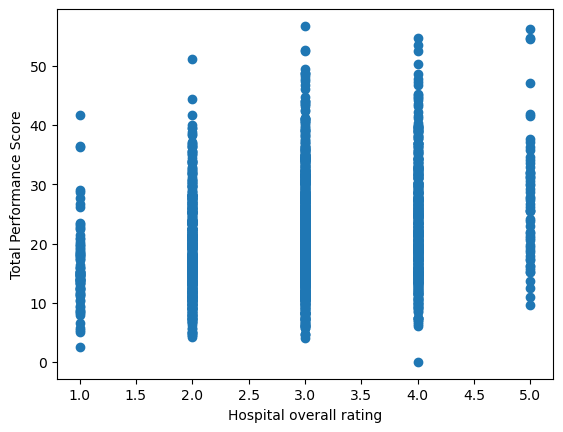

In [45]:
x_values = new_hospital_data_df['Hospital overall rating']
y_values = new_hospital_data_df['Total Performance Score']
plt.scatter(x_values,y_values)
plt.xlabel('Hospital overall rating')
plt.ylabel('Total Performance Score')
plt.show()

In [ ]:
# Add the linear regression equation and line to plot
x_values = san_diego_housing['AveRooms']
y_values = san_diego_housing['MEDV']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Rooms in House')
plt.ylabel('Median House Prices ($100,000)')
plt.show()